# NLP Project

### Importing necessary Libraries

In [1]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !pip install --upgrade gensim

In [2]:
# import nltk
# nltk.download('punkt') 
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [3]:
# from glove import Corpus, Glove
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn import metrics
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
from gensim.models import Word2Vec
from gensim.models import FastText

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm") 

In [6]:
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

## Reading the Dataset

In [7]:
dataset_main = pd.read_csv('final_dataset_casestudy.csv')

In [8]:
dataset_main.head()

Tweets     label
0  @cz_binance What's the rationale for the DOD g...  elonmusk
1  @cz_binance What's the rationale for the DOD g...  elonmusk
2  @richards_crypto @kryptochay ⚡️The Future is N...  elonmusk
3  @WatcherGuru What's the rationale for the DOD ...  elonmusk
4  Just stack #Bitcoin and hold. Life changing. #...  elonmusk

In [9]:
dataset_main.label.value_counts()

climatechange      1100
electricvehicle     918
elonmusk            868
ramadan             791
makeinindia         444
Name: label, dtype: int64

In [10]:
df_classification = dataset_main.drop_duplicates(subset=['Tweets'])

## Pre-processing


- ### Cleaning the data

In [11]:
list_stopwords = stopwords.words("english")
def preprocess(text):
    wordTokens_no_stopwords = []
    cleantext = re.sub(r'(@\S+ )|(http\S+)|(#\S+)|\\n', '', text)
    cleantext = re.sub(r'(&amp)', '', cleantext)
    cleantext = re.sub(r'[!\"#\$%&\(\)\*\+\,\.\'/:;\-<>=\?@\[\\\]\^_\{\|\}~`0-9]*', '', cleantext)
    cleantext = cleantext.encode("ascii", errors="ignore").decode()
    cleantext = cleantext.lower()
    text_tokens = cleantext.split()
    # Removing stop words
    for word in text_tokens:
        if word not in list_stopwords:
            wordTokens_no_stopwords.append(word)
    # Removing punctuation characters using regex
    wordTokens_no_stopwords_string = " ".join(wordTokens_no_stopwords)
    
    return wordTokens_no_stopwords_string

In [12]:
df_classification.head()

Tweets     label
0  @cz_binance What's the rationale for the DOD g...  elonmusk
2  @richards_crypto @kryptochay ⚡️The Future is N...  elonmusk
3  @WatcherGuru What's the rationale for the DOD ...  elonmusk
4  Just stack #Bitcoin and hold. Life changing. #...  elonmusk
5  @JP_9_1988 @disberam @bitcoinlfgo ⚡️The Future...  elonmusk

In [13]:
df_classification.loc[0, 'Tweets']

"@cz_binance What's the rationale for the DOD going up 10 million times?\nHere is a summary of our model. \nIn this video, the $DOD  model has been explained in simplicity to make sure everyone understands. \n#DOD #BSC #ElonMusk  \n@elonmusk  @cz_binance https://t.co/aHLuVuB4d3"

In [14]:
# Calling the preprocess()
df_classification['clean_text'] = df_classification['Tweets'].apply(lambda x: preprocess(x))

In [15]:
df_classification.loc[0, 'clean_text']

'whats rationale dod going million times summary model video dod model explained simplicity make sure everyone understands'

In [16]:
# removing empty rows
df_classification = df_classification[df_classification['clean_text']!='']


In [17]:
# removing tweets with less than two words
df_classification['tweet_length'] = df_classification['clean_text'].apply(lambda x: len(x.split()))
df_classification = df_classification[df_classification['tweet_length'] > 2].drop(['tweet_length'], axis=1)

In [18]:
df_classification.shape

(3273, 3)

In [19]:
# Changing the labels to their corresponding ids

# 0 --> elonmusk
# 1 --> electricvehicle
# 2 --> climatechange
# 3 --> makeinindia
# 4 --> ramadan

df_classification['label'] = df_classification['label'].map({'elonmusk':0,
                                                             'electricvehicle':1,
                                                             'climatechange':2,
                                                             'makeinindia':3,
                                                             'ramadan':4})

In [20]:
df_classification.head()

Tweets  label  \
0  @cz_binance What's the rationale for the DOD g...      0   
3  @WatcherGuru What's the rationale for the DOD ...      0   
4  Just stack #Bitcoin and hold. Life changing. #...      0   
6  @MMCrypto What's the rationale for the DOD goi...      0   
8  @VLaunchCOM What's the rationale for the DOD g...      0   

                                          clean_text  
0  whats rationale dod going million times summar...  
3  whats rationale dod going million times summar...  
4                           stack hold life changing  
6  whats rationale dod going million times summar...  
8  whats rationale dod going million times summar...

In [21]:
df_classification.drop('Tweets', axis=1, inplace=True)
df_clustering = deepcopy(df_classification)

In [22]:
df_classification.head()

label                                         clean_text
0      0  whats rationale dod going million times summar...
3      0  whats rationale dod going million times summar...
4      0                           stack hold life changing
6      0  whats rationale dod going million times summar...
8      0  whats rationale dod going million times summar...

In [23]:
df_clustering.head()

label                                         clean_text
0      0  whats rationale dod going million times summar...
3      0  whats rationale dod going million times summar...
4      0                           stack hold life changing
6      0  whats rationale dod going million times summar...
8      0  whats rationale dod going million times summar...

- ### Stemming

In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")

def stemming(text):
    snowball_stem_tokens = []
    wordTokens = text.split()
    for word in wordTokens:
        stem_word = stemmer2.stem(word)
        snowball_stem_tokens.append(stem_word)
    snowball_stem_text = " ".join(snowball_stem_tokens)
    return snowball_stem_text

# vocabulary_snowball = create_vocabulary(snowball_stem_tokens)
# print(vocabulary_snowball)

In [25]:
df_classification['stemmed_text'] = df_classification['clean_text'].apply(lambda x: stemming(x))

In [26]:
df_classification.head()

label                                         clean_text  \
0      0  whats rationale dod going million times summar...   
3      0  whats rationale dod going million times summar...   
4      0                           stack hold life changing   
6      0  whats rationale dod going million times summar...   
8      0  whats rationale dod going million times summar...   

                                        stemmed_text  
0  what rational dod go million time summari mode...  
3  what rational dod go million time summari mode...  
4                              stack hold life chang  
6  what rational dod go million time summari mode...  
8  what rational dod go million time summari mode...

- ### Lemmatization


In [27]:
# data_file = df_clustering['clean_text'].to_list()
# word_tokens = []
# for line in data_file:
#     word_tokens.append(word_tokenize(line))     # tokenize the sentences to words

# final_tokens =[]
# for sublist in word_tokens:
#     for word in sublist:
#         final_tokens.append(word)               # combining all tokens to one single list


In [28]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [29]:
lemmatizer = WordNetLemmatizer()           # Lemmatization
def lemmatization(text):
    clean_tagged_sentence = []
    lemma_list = []
    word_tokens = word_tokenize(text)
    taggedSentence = pos_tag(word_tokens)
    for tag in taggedSentence:
        if tag[1] not in {',','.','$',":",'(',')',"''","....."}:
            clean_tagged_sentence.append(tag)
    for tup in clean_tagged_sentence:
        w = lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1]))
        lemma_list.append(w)
    lemma_text = " ".join(lemma_list)

    return lemma_text

In [30]:
df_clustering['lemma_text'] = df_clustering['clean_text'].apply(lambda x: lemmatization(x))

In [31]:
df_clustering.head()

label                                         clean_text  \
0      0  whats rationale dod going million times summar...   
3      0  whats rationale dod going million times summar...   
4      0                           stack hold life changing   
6      0  whats rationale dod going million times summar...   
8      0  whats rationale dod going million times summar...   

                                          lemma_text  
0  whats rationale dod go million time summary mo...  
3  whats rationale dod go million time summary mo...  
4                             stack hold life change  
6  whats rationale dod go million time summary mo...  
8  whats rationale dod go million time summary mo...

In [32]:
#pip install Pillow


In [33]:
#conda install -c conda-forge wordcloud

- ### Data Visualization

In [34]:
from wordcloud import WordCloud


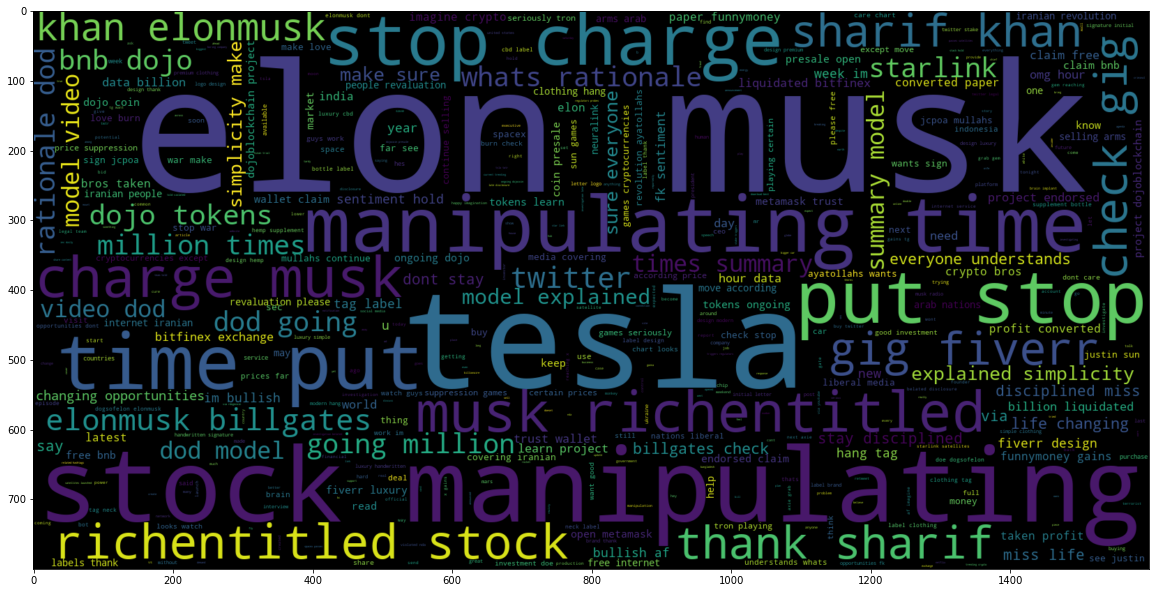

In [35]:
# 0 --> elonmusk
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 ,
               height = 800).generate(" ".join(df_classification[df_classification.label == 0].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

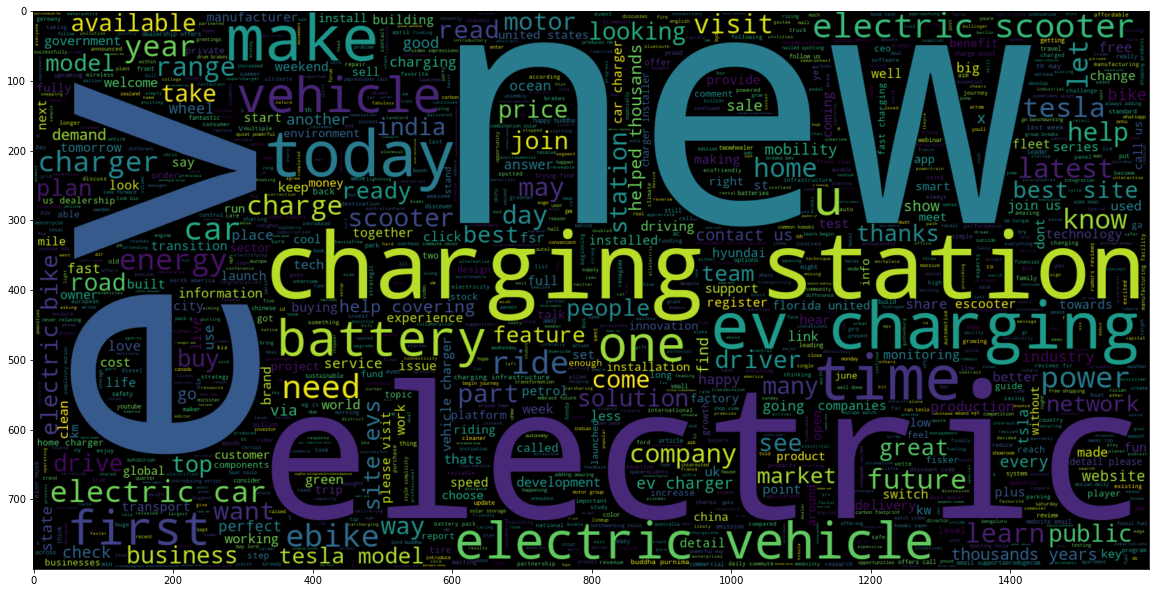

In [36]:
# 1 --> electricvehicle
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , 
               height = 800).generate(" ".join(df_classification[df_classification.label == 1].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

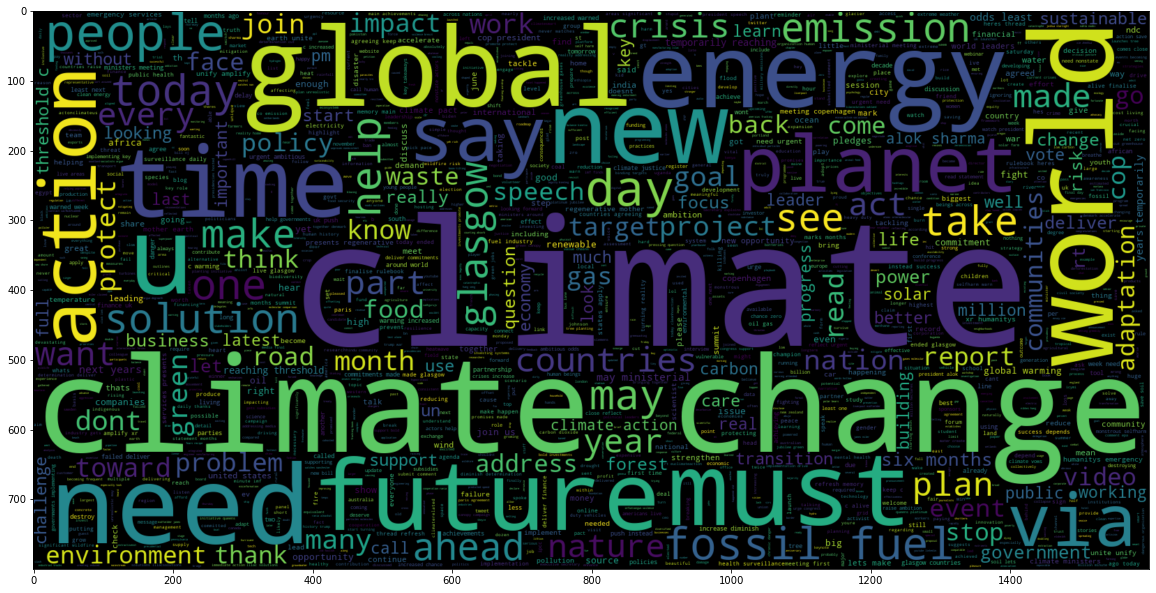

In [37]:
# 2 --> climatechange
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , 
               height = 800).generate(" ".join(df_classification[df_classification.label == 2].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

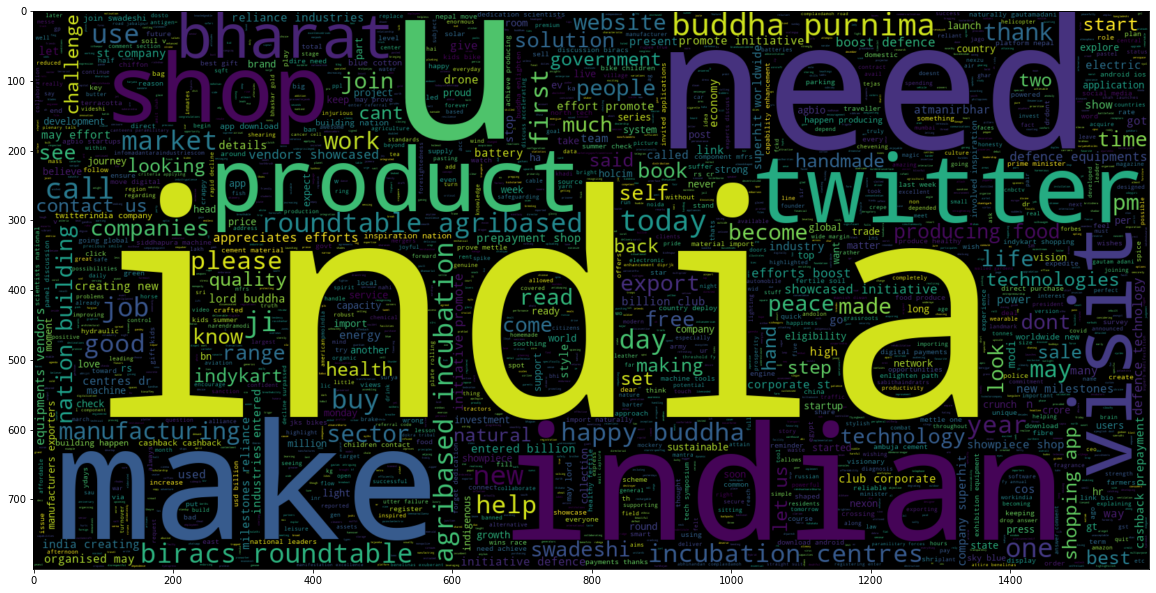

In [38]:
# 3 --> makeinindia
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , 
               height = 800).generate(" ".join(df_classification[df_classification.label == 3].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

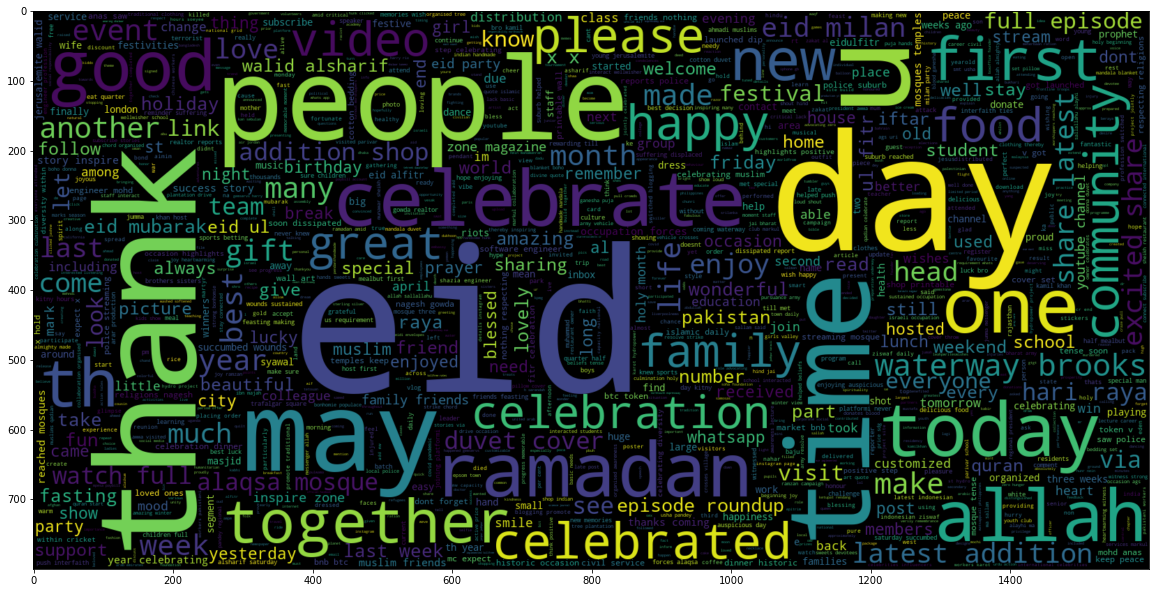

In [39]:
# 4 --> ramadan
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 ,
               height = 800).generate(" ".join(df_classification[df_classification.label == 4].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

# Text Repesentation

- ## Tf-idf

In [40]:
#Tf-idf vectorization with unigram and bigram
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))        
X_stemmed = vectorizer.fit_transform(df_classification.stemmed_text)
X_stemmed.shape

(3273, 33752)

### Splitting the dataset


In [41]:
X_stemmed = X_stemmed.toarray()
y_stemmed = df_classification['label'].values

In [42]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_stemmed, y_stemmed = shuffle(X_stemmed, y_stemmed, random_state=42)
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = \
    train_test_split(X_stemmed, y_stemmed, test_size=0.2, random_state=42)


- ## Word Embedding

# GLOVE

In [43]:
import numpy as np

fn = "glove.6B.50d.txt"
g_file = open(fn,  encoding='utf-8')

In [44]:
model={}
for line in g_file:
    parts = line.split()
    word = parts[0]
    embedding = np.array([float(val) for val in parts[1:]])
    model[word] = embedding

In [45]:
df_clustering.head()

label                                         clean_text  \
0      0  whats rationale dod going million times summar...   
3      0  whats rationale dod going million times summar...   
4      0                           stack hold life changing   
6      0  whats rationale dod going million times summar...   
8      0  whats rationale dod going million times summar...   

                                          lemma_text  
0  whats rationale dod go million time summary mo...  
3  whats rationale dod go million time summary mo...  
4                             stack hold life change  
6  whats rationale dod go million time summary mo...  
8  whats rationale dod go million time summary mo...

In [46]:
df_clustering.index = range(len(df_clustering))

In [47]:
df_clustering.filter([2468], axis=0)

label                                         clean_text  \
2468      3  seamless integration emerging technologies for...   

                                             lemma_text  
2468  seamless integration emerge technology force m...

In [48]:
doc_ls = df_clustering['lemma_text'].to_list()
finalarray = np.empty((0,50), float)
for i, doc in enumerate(doc_ls):
    tokens = doc.split()
    doc_vec_ls = []
    for word in tokens:
        if word in model.keys():
            word_vec = model[word]
            doc_vec_ls.append(word_vec)
    doc_array = np.stack(doc_vec_ls, axis=0)
    doc_array = doc_array.sum(axis=0).reshape(1, -1)
    finalarray = np.append(finalarray, doc_array, axis=0)


In [49]:
finalarray[:2, :]

array([[  2.760772  ,   0.877644  ,   4.848077  ,  -1.630755  ,
          5.93218   ,  -1.096832  ,  -0.949871  ,  -6.434898  ,
          1.114817  ,   1.50450612,  -1.421943  ,   2.9574298 ,
         -6.577732  ,  -0.404648  ,   9.20025   ,   3.353013  ,
          0.3747183 ,   0.8667742 ,   3.097071  ,  -6.39036   ,
          0.412641  ,   3.041594  ,   0.76407   ,   0.2390968 ,
          6.763801  , -16.055585  , -10.58665   ,  -2.822398  ,
          6.764736  ,  -3.50644   ,  35.187922  ,   2.50656   ,
         -6.409437  ,  -6.771482  ,   0.5149574 ,  -1.008071  ,
          2.9276217 ,   1.93602384,  -2.281845  ,  -4.4309426 ,
          0.422545  ,  -3.0683072 ,   3.50555   ,   4.213558  ,
         -3.47290746,   1.7317029 ,   4.343542  ,   7.09771   ,
         -0.837338  ,   8.353509  ],
       [  2.760772  ,   0.877644  ,   4.848077  ,  -1.630755  ,
          5.93218   ,  -1.096832  ,  -0.949871  ,  -6.434898  ,
          1.114817  ,   1.50450612,  -1.421943  ,   2.9574298 ,
   

### Splitting the dataset


In [50]:
X_lemma_glove = deepcopy(finalarray)
y_glove = df_clustering['label'].values

In [51]:
X_lemma_glove, y_glove = shuffle(X_lemma_glove, y_glove, random_state=42)
X_train_glove, X_test_glove, y_train_glove, y_test_glove= \
    train_test_split(X_lemma_glove, y_glove, test_size=0.2, random_state=42)

# WORD2VEC

In [52]:
from gensim.models.keyedvectors import KeyedVectors

In [53]:
wv_from_bin = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)  # C bin format

In [54]:
doc_ls = df_clustering['lemma_text'].to_list()
finalarray_w2v = np.empty((0,300), float)
for doc in doc_ls:
    tokens = doc.split()
    doc_vec_ls = []
    for word in tokens:
        try:
            word_vec = wv_from_bin.get_vector(word)
            doc_vec_ls.append(word_vec)
        except:
            continue
    doc_array = np.stack(doc_vec_ls, axis=0)
    doc_array = doc_array.sum(axis=0).reshape(1, -1)
    finalarray_w2v = np.append(finalarray_w2v, doc_array, axis=0)


In [55]:
finalarray_w2v[:2, :]

array([[ 0.60925293, -0.22105408, -0.17929077,  1.27539062, -0.9800415 ,
         0.28919983,  1.97558594, -1.35923767,  2.34814453, -0.62459564,
        -1.95959473, -2.39672852, -0.04200745, -0.2305603 , -1.72949219,
         1.99961853,  0.70947266,  0.50106812, -0.45928955, -1.84616089,
         0.07389832,  0.99004364,  0.12756348,  0.77798462,  0.38839722,
         0.17547607, -1.46716309,  1.6541748 , -0.14438057, -1.05554199,
        -0.75762939,  0.40405273, -1.20632935,  0.83837891,  0.65844727,
        -0.54858398,  0.55467033,  0.56542969,  1.34698486,  0.68066406,
         1.20471191, -0.21679688,  0.92002869,  0.30053711, -0.55715942,
        -1.08535767, -1.56689346,  0.01334381, -0.18865967,  0.02374268,
        -0.63647461,  0.18743896,  0.40618896, -1.48986816,  0.08349609,
         0.33813477, -1.51242065, -0.83435059,  0.87219238, -1.22753906,
        -0.33146477,  0.70684052, -1.04455566, -0.22058105, -0.09014893,
        -0.93212891, -1.20257568,  1.65936279,  0.4

### Splitting the dataset


In [56]:
X_lemma_w2v = deepcopy(finalarray_w2v)
y_w2v = df_clustering['label'].values

X_lemma_w2v, y_w2v = shuffle(X_lemma_w2v, y_w2v, random_state=42)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v= \
    train_test_split(X_lemma_w2v, y_w2v, test_size=0.2, random_state=42)

In [57]:
finalarray_w2v.shape


(3273, 300)

# Building the Machine Learning Models

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix  


 ## Classification

- ### Logistic Regression

In [198]:
from sklearn.linear_model import LogisticRegression  
classifier= LogisticRegression(random_state=0, max_iter=100,solver='liblinear')  

In [199]:
#Stemmed Dataset
classifier.fit(X_train_stemmed, y_train_stemmed)
y_pred_stem= classifier.predict(X_test_stemmed)
acc_log_stem =accuracy_score(y_test_stemmed, y_pred_stem)
acc_log_stem

0.7251908396946565

<AxesSubplot:>

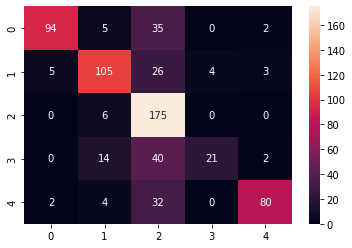

In [200]:
#Creating the Confusion matrix  
cm= confusion_matrix(y_test_stemmed,y_pred_stem)
sns.heatmap(cm, annot = True, fmt='g')

In [201]:
# Logistic Regression - Stemmed Dataset
target_names = ['elonmusk', 'electricvehicle','climatechange','makeinindia','ramadan']
print(classification_report(y_test_stemmed, y_pred_stem, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.93      0.69      0.79       136
electricvehicle       0.78      0.73      0.76       143
  climatechange       0.57      0.97      0.72       181
    makeinindia       0.84      0.27      0.41        77
        ramadan       0.92      0.68      0.78       118

       accuracy                           0.73       655
      macro avg       0.81      0.67      0.69       655
   weighted avg       0.79      0.73      0.72       655



In [202]:
#Glove Dataset  
classifier.fit(X_train_glove, y_train_glove)
y_pred_glove= classifier.predict(X_test_glove)
acc_log_glove= accuracy_score(y_test_glove, y_pred_glove)
acc_log_glove

0.7068702290076336

<AxesSubplot:>

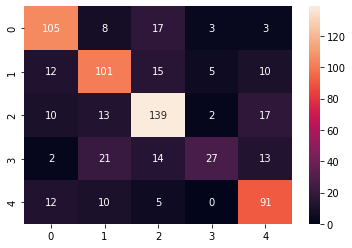

In [203]:
#Creating the Confusion matrix  
cm= confusion_matrix(y_test_glove,y_pred_glove)
sns.heatmap(cm, annot = True, fmt='g')

In [204]:
# Logistic Regression - Glove Dataset
print(classification_report(y_test_glove, y_pred_glove, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.74      0.77      0.76       136
electricvehicle       0.66      0.71      0.68       143
  climatechange       0.73      0.77      0.75       181
    makeinindia       0.73      0.35      0.47        77
        ramadan       0.68      0.77      0.72       118

       accuracy                           0.71       655
      macro avg       0.71      0.67      0.68       655
   weighted avg       0.71      0.71      0.70       655



In [205]:
#Word2Vec Dataset  
classifier.fit(X_train_w2v, y_train_w2v)
y_pred_w2v= classifier.predict(X_test_w2v)
acc_log_w2v= accuracy_score(y_test_w2v, y_pred_w2v)
acc_log_w2v

0.7374045801526717

<AxesSubplot:>

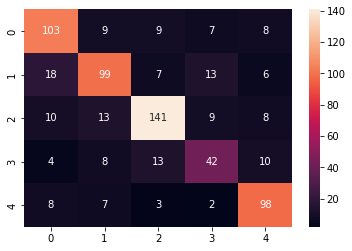

In [206]:
#Creating the Confusion matrix  
cm= confusion_matrix(y_test_w2v,y_pred_w2v)
sns.heatmap(cm, annot = True, fmt='g')


In [207]:
# Logistic Regression - Word2Vec Dataset

print(classification_report(y_test_w2v, y_pred_w2v, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.72      0.76      0.74       136
electricvehicle       0.73      0.69      0.71       143
  climatechange       0.82      0.78      0.80       181
    makeinindia       0.58      0.55      0.56        77
        ramadan       0.75      0.83      0.79       118

       accuracy                           0.74       655
      macro avg       0.72      0.72      0.72       655
   weighted avg       0.74      0.74      0.74       655



- ### K-Nearest Neighbor


In [208]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)


In [209]:
#Stemmed Dataset
knn_model.fit(X_train_stemmed, y_train_stemmed)
y_pred_stem= knn_model.predict(X_test_stemmed)
acc_knn_stem=accuracy_score(y_test_stemmed, y_pred_stem)
acc_knn_stem

0.6641221374045801

<AxesSubplot:>

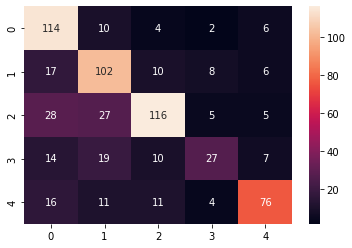

In [210]:
cm= confusion_matrix(y_test_stemmed,y_pred_stem)
sns.heatmap(cm, annot = True, fmt='g')

In [211]:
# KNN - Stemmed Dataset
print(classification_report(y_test_stemmed, y_pred_stem, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.60      0.84      0.70       136
electricvehicle       0.60      0.71      0.65       143
  climatechange       0.77      0.64      0.70       181
    makeinindia       0.59      0.35      0.44        77
        ramadan       0.76      0.64      0.70       118

       accuracy                           0.66       655
      macro avg       0.66      0.64      0.64       655
   weighted avg       0.68      0.66      0.66       655



In [218]:
#Glove Dataset
knn_model.fit(X_train_glove, y_train_glove)
y_pred_glove= knn_model.predict(X_test_glove)
acc_knn_glove= accuracy_score(y_test_glove, y_pred_glove)
acc_knn_glove

0.6244274809160305

<AxesSubplot:>

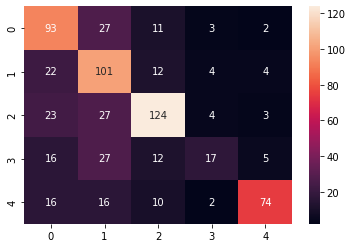

In [219]:
cm= confusion_matrix(y_test_glove,y_pred_glove)
sns.heatmap(cm, annot = True, fmt='g')

In [220]:
# KNN - Glove Dataset
print(classification_report(y_test_glove, y_pred_glove, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.55      0.68      0.61       136
electricvehicle       0.51      0.71      0.59       143
  climatechange       0.73      0.69      0.71       181
    makeinindia       0.57      0.22      0.32        77
        ramadan       0.84      0.63      0.72       118

       accuracy                           0.62       655
      macro avg       0.64      0.58      0.59       655
   weighted avg       0.65      0.62      0.62       655



In [221]:
#Word2Vec
knn_model.fit(X_train_w2v, y_train_w2v)
y_pred_w2v= knn_model.predict(X_test_w2v)
acc_knn_w2v= accuracy_score(y_test_w2v, y_pred_w2v)
acc_knn_w2v

0.6900763358778625

<AxesSubplot:>

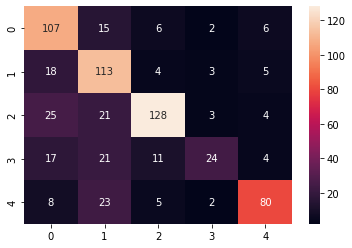

In [222]:
cm= confusion_matrix(y_test_w2v,y_pred_w2v)
sns.heatmap(cm, annot = True, fmt='g')

In [223]:
# KNN - Word2Vec Dataset
print(classification_report(y_test_w2v, y_pred_w2v, target_names=target_names))


                 precision    recall  f1-score   support

       elonmusk       0.61      0.79      0.69       136
electricvehicle       0.59      0.79      0.67       143
  climatechange       0.83      0.71      0.76       181
    makeinindia       0.71      0.31      0.43        77
        ramadan       0.81      0.68      0.74       118

       accuracy                           0.69       655
      macro avg       0.71      0.65      0.66       655
   weighted avg       0.71      0.69      0.68       655



- ### Naive Bayes Classifier

In [224]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [225]:
#Stemmed Dataset
y_pred_stem = gnb.fit(X_train_stemmed, y_train_stemmed).predict(X_test_stemmed)
acc_nb_stem= accuracy_score(y_test_stemmed, y_pred_stem)
acc_nb_stem

0.683969465648855

<AxesSubplot:>

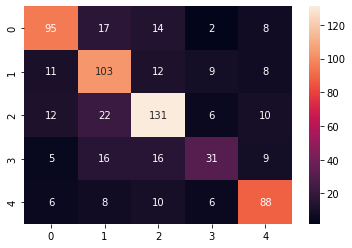

In [226]:
cm= confusion_matrix(y_test_stemmed,y_pred_stem)
sns.heatmap(cm, annot = True,fmt='g')

In [227]:
# Naive Bayes - Stemmed Dataset

print(classification_report(y_test_stemmed, y_pred_stem, target_names=target_names))

                 precision    recall  f1-score   support

       elonmusk       0.74      0.70      0.72       136
electricvehicle       0.62      0.72      0.67       143
  climatechange       0.72      0.72      0.72       181
    makeinindia       0.57      0.40      0.47        77
        ramadan       0.72      0.75      0.73       118

       accuracy                           0.68       655
      macro avg       0.67      0.66      0.66       655
   weighted avg       0.68      0.68      0.68       655



In [228]:
#Glove Dataset
y_pred_glove = gnb.fit(X_train_glove, y_train_glove).predict(X_test_glove)
acc_nb_glove= accuracy_score(y_test_glove, y_pred_glove)
acc_nb_glove

0.5633587786259542

<AxesSubplot:>

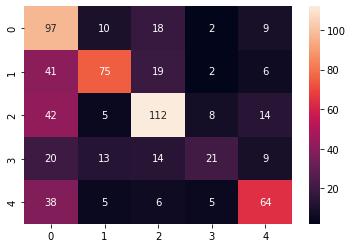

In [229]:
cm= confusion_matrix(y_test_glove,y_pred_glove)
sns.heatmap(cm, annot = True,fmt='g')

In [230]:
# Naive Bayes - Glove Dataset
print(classification_report(y_test_glove, y_pred_glove, target_names=target_names))

                 precision    recall  f1-score   support

       elonmusk       0.41      0.71      0.52       136
electricvehicle       0.69      0.52      0.60       143
  climatechange       0.66      0.62      0.64       181
    makeinindia       0.55      0.27      0.37        77
        ramadan       0.63      0.54      0.58       118

       accuracy                           0.56       655
      macro avg       0.59      0.53      0.54       655
   weighted avg       0.60      0.56      0.56       655



In [231]:
#Word2Vec Dataset
y_pred_w2v = gnb.fit(X_train_w2v, y_train_w2v).predict(X_test_w2v)
acc_nb_w2v= accuracy_score(y_test_w2v, y_pred_w2v)
acc_nb_w2v

0.5450381679389313

<AxesSubplot:>

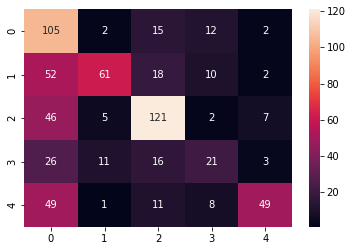

In [232]:
cm= confusion_matrix(y_test_w2v,y_pred_w2v)
sns.heatmap(cm, annot = True,fmt='g')

In [233]:
# Naive Bayes - Word2Vec Dataset
print(classification_report(y_test_w2v, y_pred_w2v, target_names=target_names))

                 precision    recall  f1-score   support

       elonmusk       0.38      0.77      0.51       136
electricvehicle       0.76      0.43      0.55       143
  climatechange       0.67      0.67      0.67       181
    makeinindia       0.40      0.27      0.32        77
        ramadan       0.78      0.42      0.54       118

       accuracy                           0.55       655
      macro avg       0.60      0.51      0.52       655
   weighted avg       0.62      0.55      0.55       655



# Comparing the Models

In [273]:
acc_score = pd.DataFrame({'TF-IDF': [acc_log_stem,acc_knn_stem,acc_nb_stem],
                          'Glove': [acc_log_glove,acc_knn_glove,acc_nb_glove],
                          'Word2Vec' : [acc_log_w2v,acc_knn_w2v,acc_nb_w2v]
                          },index=['Logistic Regression','K-Nearest Neighbor','Naive Bayes'])
acc_score.T

Logistic Regression  K-Nearest Neighbor  Naive Bayes
TF-IDF               0.725191            0.664122     0.683969
Glove                0.706870            0.624427     0.563359
Word2Vec             0.737405            0.690076     0.545038

- ## Logistic Regression with Word2Vec Dataset gave the highest accuracy of correctly classifying the dataset.

# Clustering

- # Agglomerative Clustering


- ### GLOVE Dataset

In [242]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=5)
#Glove Dataset
agglo.fit(X_train_glove)

agglo.labels_

array([0, 1, 1, ..., 2, 3, 1], dtype=int64)

In [243]:
silhouette_avg = silhouette_score(X_train_glove, agglo.labels_)
silhouette_avg

0.12097946962140235

In [244]:
np.unique(agglo.labels_)

array([0, 1, 2, 3, 4], dtype=int64)

#### Silhouette Analysis

In [245]:
%%time
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    
    # intialise agglomerative clustering
    agglo = AgglomerativeClustering(n_clusters=num_clusters)
    agglo.fit(X_train_glove)
    
    cluster_labels = agglo.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_train_glove, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.30839812519796783
For n_clusters=3, the silhouette score is 0.24461635938679566
For n_clusters=4, the silhouette score is 0.11582427838802059
For n_clusters=5, the silhouette score is 0.12097946962140235
For n_clusters=6, the silhouette score is 0.11862791742419393
For n_clusters=7, the silhouette score is 0.1218059516334671
For n_clusters=8, the silhouette score is 0.039139894366288265
For n_clusters=9, the silhouette score is 0.03774013194102199
For n_clusters=10, the silhouette score is 0.04123779528699521
Wall time: 4.31 s


- #### Silhouette Score is highest for cluster size = 2.

In [246]:
# Final model with k=2
agglo = AgglomerativeClustering(n_clusters=2)
agglo.fit(X_train_glove)
agglo.labels_

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [247]:
silhouette_agglo_glove = silhouette_score(X_train_glove, agglo.labels_)
print(silhouette_agglo_glove)

0.30839812519796783


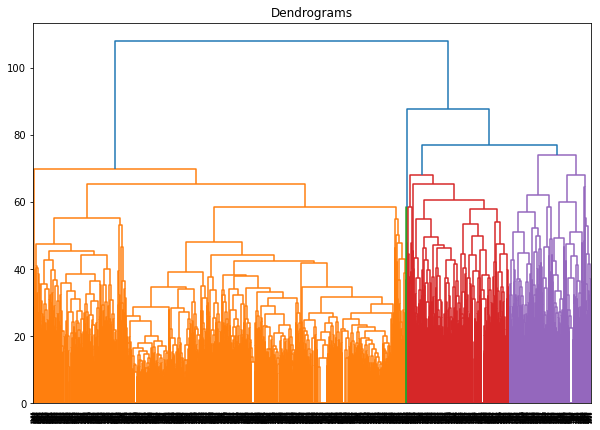

In [248]:
# Dendogram for Heirarchical Clustering for Glove Dataset
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_train_glove, method='complete'))

- ### WORD2VEC Dataset

#### Silhouette Analysis

In [249]:
%%time
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    
    # intialise agglomerative clustering
    agglo = AgglomerativeClustering(n_clusters=num_clusters)
    agglo.fit(X_train_w2v)
    
    cluster_labels = agglo.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_train_w2v, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.13341412180567255
For n_clusters=3, the silhouette score is 0.12712313018868698
For n_clusters=4, the silhouette score is 0.1315272417832028
For n_clusters=5, the silhouette score is 0.12800223914291026
For n_clusters=6, the silhouette score is 0.13313219146750246
For n_clusters=7, the silhouette score is 0.10744131390113777
For n_clusters=8, the silhouette score is 0.11145282791681793
For n_clusters=9, the silhouette score is -0.03937236792399518
For n_clusters=10, the silhouette score is -0.03647328031503309
Wall time: 10.6 s


- #### Silhouette Score is highest for cluster size = 2.

In [250]:
agglo = AgglomerativeClustering(n_clusters=2)
#Word2Vec Dataset
agglo.fit(X_train_w2v)

agglo.labels_

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [251]:
silhouette_agglo_w2v = silhouette_score(X_train_w2v, agglo.labels_)
silhouette_agglo_w2v

0.13341412180567255

In [252]:
np.unique(agglo.labels_)

array([0, 1], dtype=int64)

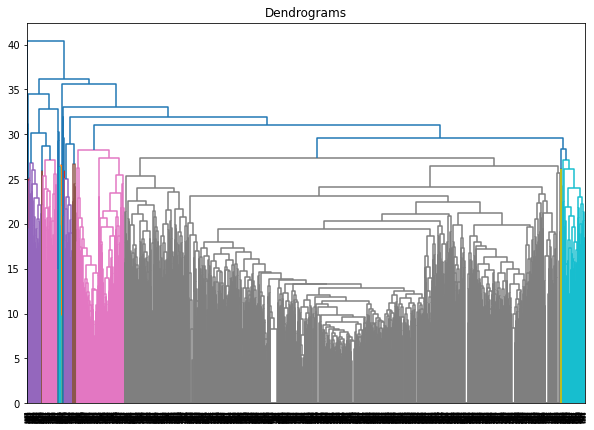

In [253]:
# Dendogram for Heirarchical Clustering for Word2Vec Dataset
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_train_w2v, method='complete'))

- # K-Means Clustering


- ### GLOVE Dataset

In [254]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, max_iter=50,random_state=15)
kmeans.fit(X_train_glove)
kmeans.labels_

array([0, 1, 1, ..., 2, 3, 1])

In [255]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4])

In [256]:
silhouette_kmeans_glove = silhouette_score(X_train_glove, kmeans.labels_)
silhouette_kmeans_glove

0.12284461039545695

Wall time: 1.97 s


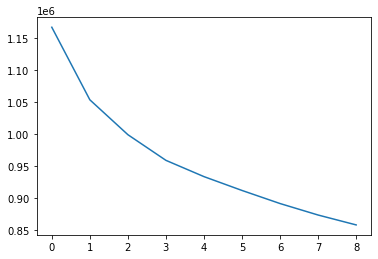

In [257]:
%%time
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=7)
    kmeans.fit(X_train_glove)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

#### Silhouette Analysis

In [258]:
%%time
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=12)
    kmeans.fit(X_train_glove)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_train_glove, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3191828844982135
For n_clusters=3, the silhouette score is 0.20139406109431082
For n_clusters=4, the silhouette score is 0.12656156580794728
For n_clusters=5, the silhouette score is 0.11395251058110775
For n_clusters=6, the silhouette score is 0.07874740828118149
For n_clusters=7, the silhouette score is 0.1268255916957711
For n_clusters=8, the silhouette score is 0.08021414263188048
Wall time: 2.13 s


- #### Silhouette Score is highest for cluster size = 2.

In [259]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50,random_state=15)
kmeans.fit(X_train_glove)

KMeans(max_iter=50, n_clusters=2, random_state=15)

In [260]:
cluster_labels = kmeans.labels_
silhouette_kmeans_glove = silhouette_score(X_train_glove, cluster_labels)
print(silhouette_kmeans_glove)

0.3191748854123573


In [261]:
 kmeans.labels_


array([1, 0, 0, ..., 1, 0, 0])

In [ ]:


X_lemma_glove.s

- ### WORD2VEC Dataset

Wall time: 3.46 s


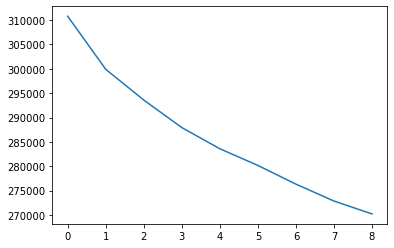

In [262]:
%%time
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=7)
    kmeans.fit(X_train_w2v)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

#### Silhouette Analysis

In [263]:
%%time
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=12)
    kmeans.fit(X_train_w2v)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_train_w2v, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.1662954565034265
For n_clusters=3, the silhouette score is 0.15485986407846758
For n_clusters=4, the silhouette score is 0.1468529794227192
For n_clusters=5, the silhouette score is 0.1196735211289152
For n_clusters=6, the silhouette score is 0.05638525106091184
For n_clusters=7, the silhouette score is 0.08034418051481669
For n_clusters=8, the silhouette score is 0.050409299015036296
Wall time: 3.89 s


- #### Silhouette Score is highest for cluster size = 2.

In [264]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50,random_state=15)
kmeans.fit(X_train_w2v)

KMeans(max_iter=50, n_clusters=2, random_state=15)

In [265]:
 kmeans.labels_


array([1, 0, 0, ..., 0, 0, 0])

In [266]:
np.unique(kmeans.labels_)

array([0, 1])

In [267]:
silhouette_kmeans_w2v = silhouette_score(X_train_w2v, kmeans.labels_)
silhouette_kmeans_w2v

0.16608425684318856

# Comparing the Models

In [270]:
sil_score = pd.DataFrame({'Agglomerative': [silhouette_agglo_glove,silhouette_agglo_w2v],
                      'K-Means' : [silhouette_kmeans_glove,silhouette_kmeans_w2v]
                      },index=["Glove","Word2Vec"])

In [271]:
sil_score

Agglomerative   K-Means
Glove          0.308398  0.319175
Word2Vec       0.133414  0.166084

- ### Glove Dataset gives the highest accuracy on K-Means Clustering.
- ### There are high chances that there will only be 2 clusters since three out of the five are very much related topics, i.e #elonmusk, #electricvehicle and #climatechange. Out of the five, #ramadan and #makeinindia also seems to be clustered together due to various reasons.One reason could be that data for that label is less compared to others,also there could be many tweets connecting india & ramadan which is a major festival in India.